In [1]:
################################
# Scientific imports
################################
import gc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, statistics
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import SpectralClustering
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (16,4)
sb.set()

In [2]:
fitsList = np.load("fitslist.npy")

In [3]:
def LoadListGeneral(f):
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # I don't know why but this makes it work better
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])       # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    return lst

def LoadList(itemtype="all"):
    
    foundflag=False
    
    # itemtype = (S)tar, (P)lanet, (E)clipsing (B)inary, or (B)ack (E)clipsing (B)inary
    if itemtype.lower() in ["s", "star", "all"]:
        foundflag = True
        starList = list(map(int,LoadListGeneral(sl)))
        print("Loading star list: {}".format(sl))
    if itemtype.lower() in ["p", "planet", "all"]:
        foundflag = True
        planetList = list(map(int,LoadListGeneral(pl)))
        print ("loading planet list: {}".format(pl))
    if itemtype.lower() in ["eb", "eclipsing binary", "eclipsingbinary", "all"]:
        foundflag = True
        ebList = list(map(int,LoadListGeneral(ebl)))
        print ("loading eb list: {}".format(ebl))
    if itemtype.lower() in ["beb", "back eclipsing binary", "backeclipsingbinary", "all"]:
        foundflag = True
        bebList = list(map(int,LoadListGeneral(bebl)))
        print ("loading beb list: {}".format(bebl))
        
    if foundflag:
        #global alllists
        alllists = {"s": starList, "p": planetList, "eb": ebList, "beb": bebList}
        return (alllists)
    else:
        # If an invalid selection has been entered
        print("You must enter either:\n"
               "* \"S\" (or \"Star\")\n"
               "* \"P\" (or \"Planet\")\n"
               "* \"EB\" (or \"Eclipsing Binary\")\n"
               "* \"BEB\" (or \"Back Eclipsing Binary\")")

def IsThisAStar(n):
    return n in alllists["s"]
    
def IsThisAPlanet(n):
    return n in alllists["p"]

def IsThisAEB(n):
    return n in alllists["eb"]

def IsThisABEB(n):
    return n in alllists["beb"]

# Function to tell you what an item is
def WhatIsMyLC(n):
    lbl = []
    lbl.append("Star") if IsThisAStar(n) else lbl
    lbl.append("Planet") if IsThisAPlanet(n) else lbl
    lbl.append("EB") if IsThisAEB(n) else lbl
    lbl.append("BRB") if IsThisABEB(n) else lbl
    
    return "UNKNOWN" if lbl==[] else lbl

# Purely for convenience
def CurrentLC():
    return ("File № {} - {}".format(lastRandom["number"], lastRandom["id"]))

def DrawACurve(n=None):
    rndFile = random.randint(0,len(fitsList)) if n == None else n
    fitsFile = fitsList[rndFile]
    
    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
        # extension.
        duration = (hdulist[1].header['LIVETIME'])

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # Start figure and axis.
    fig, ax = plt.subplots()

    # Plot the timeseries in black circles.
    ## Using the [1:-1] identifier to cut off the leading and trailing zeroes

    ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)

    # Let's label the axes and define a title for the figure.
    fig.suptitle("File № {} - {}".format(rndFile,obj))
    ax.set_ylabel("PDCSAP Flux (e-/s)")
    ax.set_xlabel("Time (TBJD)")

    # Adjust the left margin so the y-axis label shows up.
    plt.subplots_adjust(left=0.15)
    #plt.figure(figsize=(2,8))
    plt.show()

def DrawLC(N=-1):
    rndFile = random.randint(0,len(fitsList))
    #print("FILE IS {}".format(rndFile))
    #fileNum = fitsList[rndFile]
    fitsFile = fitsList[rndFile] if N==-1 else fitsList[N]

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector))


In [4]:
pl="tsop301_planet_data.txt"
sl="tsop301_star_data.txt"
ebl="tsop301_eb_data.txt"
bebl="tsop301_backeb_data.txt"

#starList = []
#planetList = []
#ebList = []
#bebList = []

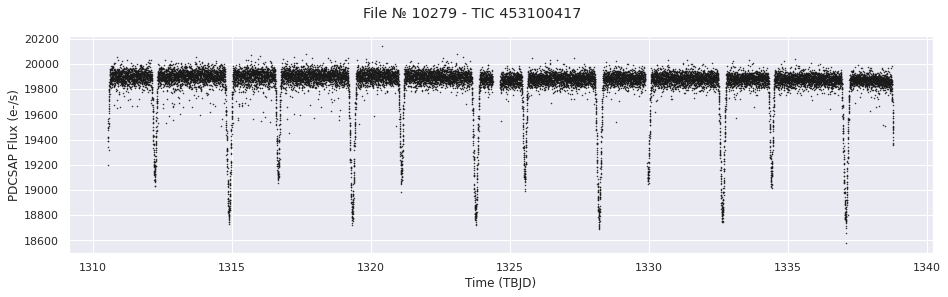

In [5]:
MASTERCURVE = 10279
DrawACurve(MASTERCURVE)

In [34]:
def NormaliseFlux(f):
    
    # Get the info
    #x,y,f,o,_ = DrawLC(f)
    
    # Standardise the Time Series (x co-ords)
    #x[:] = [number - 1310 for number in x]
    
    # Normalise the Flux (y co-ords)
    mean = np.median(f)
    std=np.std(f)
    f[:] = [(number/mean) for number in f]
    #f[:] = [np.nan if number==0 else (number/mean) for number in f]
    
    # Update deviation
    #dif = max(y)-min(y)
    #print("Deviation is {}".format(dif))
    #deviation = dif if dif > deviation else deviation
    
    # Add to list
    return (f)

#print("Maximum deviation is {}".format(deviation))
#deviation = math.ceil((deviation * 10))/10
#print("Maximum deviation is {}".format(deviation))

In [26]:
fluxList = np.load("fluxlist.npy")

In [27]:
fluxList[0]

array([     0.      , 179952.      , 179979.34375 , ..., 181044.296875,
       181062.84375 ,      0.      ])

In [28]:
len(fluxList[0])

20340

In [48]:
#newFluxList = [x[1:-1] for x in fluxList]
newFluxList = np.load("fluxlist-endschoppedoff.npy")

In [49]:
newFluxList[0]

array([0.99149246, 0.99164311, 0.98993087, ..., 0.9968259 , 0.99751075,
       0.99761294])

In [29]:
len(newFluxList[0])

20338

In [15]:
#np.save("fluxlist-endschoppedoff", newFluxList)
del fluxList
gc.collect()

3000

In [50]:
normalisedFluxList = [NormaliseFlux(x) for x in newFluxList]

In [51]:
len(normalisedFluxList)

16000

In [52]:
normalisedFluxList[0]

array([0.99149246, 0.99164311, 0.98993087, ..., 0.9968259 , 0.99751075,
       0.99761294])

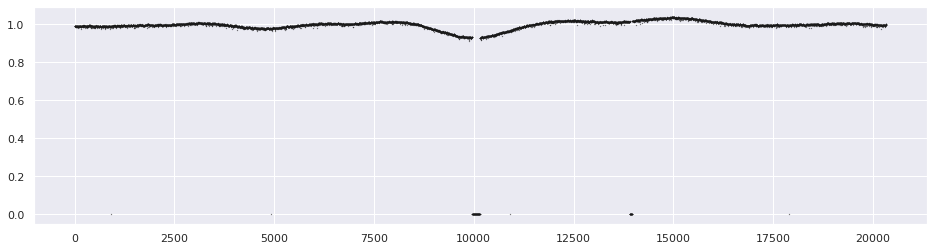

In [53]:
plt.plot(normalisedFluxList[0], 'k.', markersize=0.5)

In [15]:
np.save("fluxlist-normalised", normalisedFluxList)

In [55]:
try:
    del normOnePlanetFlux
except:
    print("That Object Doesn't Exist Yet!")

normOnePlanetFlux = [NormaliseFlux(x) for x in np.load("None_Or_One_Exoplanet.npy")]
np.save("None_Or_One_Exoplanet_NORMALISED.npy", normOnePlanetFlux)

In [54]:
np.prod(normalisedFluxList[0])

0.0

In [3]:
Q = np.load("ZeroOrOneFoldedFluxes.npy")

ValueError: Object arrays cannot be loaded when allow_pickle=False